In [144]:
import os
from astropy.io import ascii
import math
from astropy.coordinates import Angle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [161]:
ObjectFile = 'n2419c.selected'
CenterLine = 'n2419c             7:38:09.20   38:51:12.0  2000.0 PA=50.000 ##'
ha0 = 0
PA0 = 50
blue = 4000
red = 9000
sep_slit = 2
min_slit = 10
slit_width = 1
equinox = 2000

## List any necessary constants here

In [162]:
CODE_AS = -2
PRIMARY = 1
FLDCEN_X = 0
FLDCEN_Y = 270
FLIP = -1
YMSKMIN = 187.3
YMSKMAX = 479.1
XUPP_LIM = 498
XLOW_LIM = -498
YCAMCEN = 700
RADVIGN = 302
GAP1CEN =        -254.4          # CCD gap in arcsec -- center
GAP1HWD =           5.2          # CCD gap in arcsec -- half-wid
GAP2CEN =           0.0          # CCD gap in arcsec -- center
GAP2HWD =           5.2          # CCD gap in arcsec -- half-wid
GAP3CEN =         254.4          # CCD gap in arcsec -- center
GAP3HWD =           5.2          # CCD gap in arcsec -- half-wid


In [163]:
def degtorad(angle):
    return float(angle*np.pi/180)
def radtodeg(radians):
    return float(radians*57.295779513082320877)
def hhmmsstodegrees(hours):
    return Angle(str(hours)+' hours').degree
def ddmmsstodegrees(dms):
    return Angle(str(dms)+ ' degrees').degree

In [164]:
def InputDataInit():
    InputData={}
    InputData['DEF_BOXR']=0.5*4 # arcseconds for alignment boxes
    InputData['DEF_SLWID']=1 # default slit width arcseconds
    InputData['DEF_HLEN']=5 # minimum slit length
    InputData['RA0_FLD']=degtorad(hhmmsstodegrees(CenterLine.split()[1]))
    InputData['DEC0_FLD']=degtorad(ddmmsstodegrees(CenterLine.split()[2]))
    InputData['HA_FLD']=degtorad(ha0*15)
    InputData['PA_ROT']=degtorad(PA0)
    InputData['TEMP']=0
    InputData['PRES']=600
    InputData['WAVER']=7000*1e-4
    InputData['WAVEMN']=blue*1e-4
    InputData['WAVEMX']=red*1e-4
    InputData['SLIT_GAP'] = sep_slit
    InputData['DEF_HLEN'] = 0.5 * min_slit
    InputData['DEF_SLWID'] = slit_width
    InputData['STD_EQX'] = equinox
    InputData['RA_FLD']=InputData['RA0_FLD'] # no refraction
    InputData['DEC_FLD']=InputData['DEC0_FLD']
    InputData['PROJ_LEN']=True
    return InputData
    

In [165]:
def TargetInit():
    TargetData=[]
 
    data = ascii.read(ObjectFile, format='no_header', names=['id','ra','dec','equinox','mag','band','priority','nlist','selcode','pangle'])
    for i in range(len(data)):
        Target={}
        Target['INDEX']=i
        Target['IDSTR']=data['id'][i]
        ra0=degtorad(hhmmsstodegrees(data['ra'][i]))
        Target['RA0']=ra0
        dec0=degtorad(ddmmsstodegrees(data['dec'][i]))
        Target['DEC0']=dec0
        Target['RA']=Target['RA0'] # no refraction
        Target['DEC']=Target['DEC0']
        Target['MAG']=data['mag'][i]
        Target['PBAND']=data['band'][i][0]
        l1=InputData['DEF_HLEN']
        l2=InputData['DEF_HLEN']
        selcode=0
        nlist=PRIMARY
        Target['PCODE']=data['priority'][i]
        Target['STD_EQX']=data['equinox'][i]
        if data['priority'][i]==CODE_AS:
                l1 = InputData['DEF_BOXR']
                l2 = InputData['DEF_BOXR']
        Target['PA']=data['pangle'][i]
 
        if Target['PCODE']==CODE_AS:
                print("Star %s is an alignment star" % Target['IDSTR'])
                Target['PA']=''
                Target['SLWID']=2*InputData['DEF_BOXR']
        else:
                Target['SLWID']=InputData['DEF_SLWID']
        Target['SAMPL']=nlist
        Target['SEL']=data['selcode'][i]
        
        Target['LEN1']=l1
        Target['LEN2']=l2
        TargetData.append(Target)
        
    return(TargetData)

In [166]:
# read input data
InputData = InputDataInit()
# read targets
TargetData = TargetInit()
print(TargetData[0])

Star N2419-D17 is an alignment star
Star N2419-S130 is an alignment star
Star N2419-S147 is an alignment star
Star N2419-S1601 is an alignment star
Star N2419-S1778 is an alignment star
Star N2419-S345 is an alignment star
{'INDEX': 0, 'IDSTR': 'N2419-D17', 'RA0': 2.0002502972113687, 'DEC0': 0.6796521546776157, 'RA': 2.0002502972113687, 'DEC': 0.6796521546776157, 'MAG': 17.52, 'PBAND': 'I', 'PCODE': -2, 'STD_EQX': 2000, 'PA': '', 'SLWID': 4.0, 'SAMPL': 1, 'SEL': 1, 'LEN1': 2.0, 'LEN2': 2.0}


## Calculate position with reference to telescope axis

In [167]:
def fld2telax(InputData):
    r = degtorad(np.sqrt(FLDCEN_X*FLDCEN_X+FLDCEN_Y*FLDCEN_Y)/3600)
    pa_fld = np.arctan2(FLDCEN_Y,FLDCEN_X)
    cosr = np.cos(r)
    sinr = np.sin(r)
    cosd = np.cos(InputData['DEC_FLD'])
    sind = np.sin(InputData['DEC_FLD'])
    cost = np.cos(InputData['PA_ROT']-pa_fld)
    sint = np.sin(InputData['PA_ROT']-pa_fld)
    sina = sinr*sint/cosd
    cosa = np.sqrt(1-sina**2)
    InputData['RA_TEL']=InputData['RA_FLD']
    InputData['DEC_TEL']=np.arcsin((sind*cosd*cosa-cosr*sinr*cost)/(cosr*cosd*cosa-sinr*sind*cost))
    return InputData

In [168]:
InputData = fld2telax(InputData)
InputData

{'DEC0_FLD': 0.6781185920415301,
 'DEC_FLD': 0.6781185920415301,
 'DEC_TEL': 0.67711612712619529,
 'DEF_BOXR': 2.0,
 'DEF_HLEN': 5.0,
 'DEF_SLWID': 1,
 'HA_FLD': 0.0,
 'PA_ROT': 0.8726646259971648,
 'PRES': 600,
 'PROJ_LEN': True,
 'RA0_FLD': 1.999071036413438,
 'RA_FLD': 1.999071036413438,
 'RA_TEL': 1.999071036413438,
 'SLIT_GAP': 2,
 'STD_EQX': 2000,
 'TEMP': 0,
 'WAVEMN': 0.4,
 'WAVEMX': 0.9,
 'WAVER': 0.7000000000000001}

## Calculate position of targets with reference to telescope axis

In [169]:
def tel_coords(InputData, TargetData):
    ra0 = InputData['RA_TEL']
    dec0 = InputData['DEC_TEL']
    pa0 = InputData['PA_ROT']
    for i in range(len(TargetData)):
        target = TargetData[i]
        dec_obj = target['DEC']
        del_ra = target['RA']-ra0
        cosr = np.sin(dec_obj) * np.sin(dec0) + np.cos(dec_obj) * np.cos(dec0) * np.cos(del_ra)
        r = np.arccos(cosr)
        
        sinp = np.cos(dec_obj) * np.sin(del_ra) / np.sqrt(1-cosr*cosr)
        cosp = np.sqrt(max((1. - sinp*sinp),0))
        if (dec_obj < dec0):
                cosp = cosp * -1
        p = np.arctan2(sinp, cosp)
        
        r = np.tan(r)*206264.8


        target['XARCS'] = r * np.cos(pa0-p)
        target['YARCS'] = r * np.sin(pa0-p)
        
        if target['PA'] == '':
                target['RELPA'] = ''
                rangle=0
        else:
            target['RELPA'] = target['PA']-pa0
            rangle = target['RELPA']
            
        xgeom = FLIP * np.cos(rangle)
        ygeom = np.sin(rangle)
        
        if InputData['PROJ_LEN'] is True:
            xgeom = xgeom / np.abs(np.cos(rangle))
            ygeom = ygeom / np.abs(np.cos(rangle))
            
        if xgeom > 0:
            target['X1'] = target['XARCS']-target['LEN1']* xgeom
            target['Y1'] = target['YARCS']-target['LEN1']* ygeom
            target['X2'] = target['XARCS']+target['LEN2']* xgeom
            target['Y2'] = target['YARCS']+target['LEN2']* ygeom
        else:
            target['X2'] = target['XARCS']-target['LEN1']* xgeom
            target['Y2'] = target['YARCS']-target['LEN1']* ygeom
            target['X1'] = target['XARCS']+target['LEN2']* xgeom
            target['Y1'] = target['YARCS']+target['LEN2']* ygeom
            
        x=target['XARCS']
        y=target['YARCS']
        target['STAT'] = chk_stat(x,y)
        TargetData[i]=target
    return TargetData
        
def chk_stat(x,y):
    r = np.sqrt(x**2+y**2)
    if r>600:
        return False
    if y<YMSKMIN:
        return False
    if y>YMSKMAX:
        return False
    if x>XUPP_LIM or x<XLOW_LIM:
        return False
    if x>-0.98273*y+833.0:
        return False
    if (x**2+(y-YCAMCEN)**2 < RADVIGN**2):
        return False
    if (np.abs(x-GAP1CEN))< GAP1HWD:
            return False
    if (np.abs(x-GAP2CEN))< GAP2HWD:
            return False
    if (np.abs(x-GAP3CEN))< GAP3HWD:
            return False
        
    return True
    
                
        

In [170]:
TargetData = tel_coords(InputData, TargetData)
TargetData[0]

{'DEC': 0.6796521546776157,
 'DEC0': 0.6796521546776157,
 'IDSTR': 'N2419-D17',
 'INDEX': 0,
 'LEN1': 2.0,
 'LEN2': 2.0,
 'MAG': 17.52,
 'PA': '',
 'PBAND': 'I',
 'PCODE': -2,
 'RA': 2.0002502972113687,
 'RA0': 2.0002502972113687,
 'RELPA': '',
 'SAMPL': 1,
 'SEL': 1,
 'SLWID': 4.0,
 'STAT': True,
 'STD_EQX': 2000,
 'X1': 479.2120477872989,
 'X2': 483.2120477872989,
 'XARCS': 481.2120477872989,
 'Y1': 279.15783555606924,
 'Y2': 279.15783555606924,
 'YARCS': 279.15783555606924}

In [171]:
x = [x['XARCS'] for x in TargetData]
y = [x['YARCS'] for x in TargetData]

(0, 400)

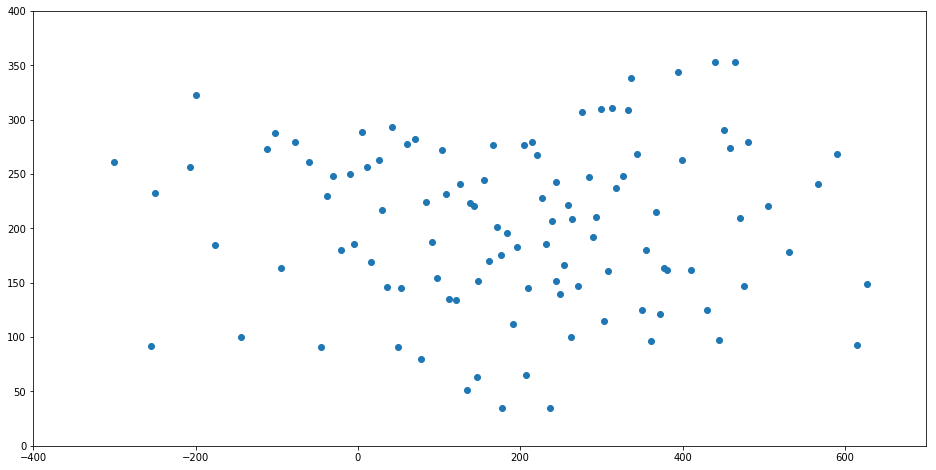

In [173]:
plt.figure(figsize=(16,8))
plt.plot(x,y,'o')
plt.xlim(-400,700)
plt.ylim(0,400)